# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Hector A. Barriga-Acosta
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction: Business Problem

In this project we will compare the **(dis)similarities that multicultural cities have** from the perspective of clusters of coffee shops.

New York City, Toronto and Paris belong to the top ten multicultural cities in the world. From the "center" of each city we will consider 50 coffee shops within a radius of 1km. We will analyze similarities among clusters of coffee shops in each area. 

For example, **is it true that in all clusters of coffee shops there are an executive offices, or supermarkets, or restaurants, or parks nearby?**

**This problem fits to the audience that wish to open a coffee shop branch in a potentially multicultural city.** This analysis would suggest that the audience will success by openning a new coffee shop regardless there is already competition around.

Let's say I want to open a new coffee shop in Mexico City which is known to have a wide veriety of culture (you can thing of any other city with this feature, not necessarily a big city). I might fear I won't have success because there are already coffee shops in the location that I like, I'm afraid of the competition. Now let's assume that clusters of coffee shops in multicultural cities share the fact that there are parks and museums closeby. **The following report will tell me whether is reliable to take the risk by openning a new branch** only by looking at the type of venues close to the location.

# Data

Factors that will influence our decission are:
* number and distance of existing venues within a radius if 500 meters from each coffee place
* distance of coffee shops from city center

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Google Maps API reverse geocoding**
* number of venues and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Paris, Manhatan and Toronto centers will be obtained using **Google Maps API geocoding**

Let's first import the required libraries for this study.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import matplotlib.pyplot as plt
%matplotlib inline 

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         235 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2021.4.13-~ --> conda-forge::ca-certificates-

### Neighborhood Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which consists of the region captured by circles with coffee shops as centers and located within a radius of 5 killometers around each city.

Let's first find the latitude & longitude of each city, using specific, well known address and Google Maps geocoding API.

In [2]:
paris = 'Paris, France'
nyc =  'New York City, NY '
toronto = 'Toronto, Canada'

cities = [paris, nyc, toronto]
locations = []

for address in cities:
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    locations.append([location.latitude, location.longitude])
    print(address+", coordinates: "+ str(location.latitude)+" "+str(location.longitude))


Paris, France, coordinates: 48.8566969 2.3514616
New York City, NY , coordinates: 40.7127281 -74.0060152
Toronto, Canada, coordinates: 43.6534817 -79.3839347


### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on coffee shops in each city.

We're interested in coffee shops that are close to city center. Then we will include in our list any type of venues that are close to each coffee shop within a radius if 500 meters.

Set up the credentials.

In [3]:
CLIENT_ID = 'C1JSXBICKQBK2ZFP4N1TLFJKVTUUUVXZXK04VCA3KDUXBKHD' # your Foursquare ID
CLIENT_SECRET = 'LEPF0AFLCLTSBB4JP0EQMLFTEHIMICN0HJHUFQ45PG3JW0EP' # your Foursquare Secret
ACCESS_TOKEN = 'H3PYWJXU1FMI5WOPV4SOYH1EFOWCMGFN0CTOW5XOUMFFRSJB' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 200
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: C1JSXBICKQBK2ZFP4N1TLFJKVTUUUVXZXK04VCA3KDUXBKHD
CLIENT_SECRET:LEPF0AFLCLTSBB4JP0EQMLFTEHIMICN0HJHUFQ45PG3JW0EP


Create a data frame for each city containing name and coordinates per coffee shop.

In [4]:
data_frames = []
search_query = 'Coffee'

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


for latitude, longitude in locations:
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius=5000&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, LIMIT)
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a dataframe
    dataframe = json_normalize(venues)

    # keep only columns that include venue name, latitude and longitude
    filtered_columns = ['name', 'location.lat', 'location.lng'] #+ [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    #dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    
    data_frames.append(dataframe_filtered)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [5]:
print(data_frames[0].shape)
data_frames[0].head()

(50, 3)


,name,lat,lng
0,Coffee Crêpes,48.858841,2.340802
1,Coffee Parisien,48.852607,2.334536
2,Starbucks Coffee - kiosque,48.875763,2.358857
3,Super Wild Coffee,48.875763,2.358857
4,Thalone's Coffee,48.859264,2.348910


In [6]:
print(data_frames[2].shape)
data_frames[2].head()

(50, 3)


,name,lat,lng
0,HotBlack Coffee,43.650364,-79.388669
1,Timothy's World Coffee,43.653436,-79.382314
2,Timothy's World Coffee,43.654053,-79.388090
3,Timothy's World Coffee,43.654270,-79.387448
4,Timothy's World Coffee,43.652135,-79.381172


In [7]:
print(data_frames[1].shape)
data_frames[1].head()

(50, 3)


,name,lat,lng
0,Blue Spoon Coffee Co.,40.714428,-74.006859
1,Kam Hing Coffee Shop 金興,40.718017,-73.999210
2,For Five Coffee Roasters,40.709554,-74.010576
3,Coffee & Donut Cart,40.712689,-74.009985
4,Kaigo Coffee Room,40.718633,-74.000367


Here we present the maps for each city with the coffee shop locations.
The red point represents the center of the city whereas blue points are coffee shops' locations.

In [8]:
maps = []

for i in range(3):
    venues_map = folium.Map(location=[locations[i][0], locations[i][1]], zoom_start=13) # generate map centred around the Conrad Hotel

    # add a red circle marker to represent the Conrad Hotel
    folium.CircleMarker(
        [locations[i][0], locations[i][1]],
        radius=10,
        color='red',
        #popup='',
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(venues_map)

    # add the Italian restaurants as blue circle markers
    for lat, lng in zip(data_frames[i].lat, data_frames[i].lng):#, data_frames[i].name):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color='blue',
            #popup=label,
            fill = True,
            fill_color='blue',
            fill_opacity=0.6
        ).add_to(venues_map)

    maps.append(venues_map)


### Map of Paris

In [9]:
maps[0]

### Map of Manhatan

In [10]:
maps[1]

### Map of Toronto

In [11]:
maps[2]

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on (dis)similarities and optimal locations for new coffee shops!

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting venues around coffee shops of the cities Paris, NYC and Toronto. We will limit our analysis to venues in an area ~500m around each coffee shop.

In first step we have collected the required **data: location of coffee shops in an area ~2km around city center**(using the Foursquare API).

Second step in our analysis will be creation of **clusters of locations for the 10 most popular venues** around each coffee shop. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders. Also, we find the value for **k that optimizes such clustering**.


and exploration of '**venues**' around different coffee shops of each city - we will use **heatmaps** to identify correlation (if exists) between venues and coffee shops. 

In third and final step we will focus on '**all venues combined**' around different coffee shops of each city - we will use **heatmaps** to identify correlation (if exists) between venues and coffee shops. 


## Analysis <a name="analysis"></a>

Let's **create a function to explore venues** nearby each coffee shop within a radius of 500 meters (this distance captures a good portion of the neighborhood).


In [12]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
      
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We **save the values on a list** containing a data frame per city.

In [14]:
venues = []

for i in range(3):
    venues.append(getNearbyVenues(names=data_frames[i]['name'],
                                   latitudes=data_frames[i]['lat'],
                                   longitudes=data_frames[i]['lng']
                                  ))

In [15]:
paris_venues = venues[0]
nyc_venues = venues[1]
toronto_venues = venues[2]

In [78]:
print(paris_venues.shape)
paris_venues.head()

(3643, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Coffee Crêpes,48.858841,2.340802,Place du Louvre,48.859841,2.340822,Plaza
1,Coffee Crêpes,48.858841,2.340802,Église Saint-Germain-l'Auxerrois (Église Saint...,48.859520,2.341306,Church
2,Coffee Crêpes,48.858841,2.340802,Coffee Crêpes,48.858841,2.340802,Coffee Shop
3,Coffee Crêpes,48.858841,2.340802,Cour Carrée du Louvre,48.860360,2.338543,Pedestrian Plaza
4,Coffee Crêpes,48.858841,2.340802,Pont des Arts,48.858565,2.337635,Bridge


In [17]:
print(nyc_venues.shape)
nyc_venues.head()

(4960, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Blue Spoon Coffee Co.,40.714428,-74.006859,Los Tacos No. 1,40.714267,-74.008756,Taco Place
1,Blue Spoon Coffee Co.,40.714428,-74.006859,Takahachi Bakery,40.713653,-74.008804,Bakery
2,Blue Spoon Coffee Co.,40.714428,-74.006859,Heyday,40.715726,-74.007767,Spa
3,Blue Spoon Coffee Co.,40.714428,-74.006859,Philip Williams Posters,40.715284,-74.008781,Antique Shop
4,Blue Spoon Coffee Co.,40.714428,-74.006859,Korin,40.714824,-74.009404,Furniture / Home Store


In [18]:
print(toronto_venues.shape)
toronto_venues.head()

(3805, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,HotBlack Coffee,43.650364,-79.388669,Friendly Stranger - Cannabis Culture Shop,43.650196,-79.388511,Smoke Shop
1,HotBlack Coffee,43.650364,-79.388669,JaBistro,43.649687,-79.388090,Sushi Restaurant
2,HotBlack Coffee,43.650364,-79.388669,Umbra Concept Store,43.650417,-79.391136,Furniture / Home Store
3,HotBlack Coffee,43.650364,-79.388669,Shangri-La Toronto,43.649129,-79.386557,Hotel
4,HotBlack Coffee,43.650364,-79.388669,Four Seasons Centre for the Performing Arts,43.650592,-79.385806,Concert Hall


In [19]:
print('There are {} uniques categories.'.format(len(paris_venues['Venue Category'].unique())))
paris_venues.groupby('Neighborhood').count().head()

There are 242 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Araku Coffee,70,70,70,70,70,70
Arômes Coffee Shop,100,100,100,100,100,100
Blackburn Coffee,45,45,45,45,45,45
Bombay Coffee,74,74,74,74,74,74
Caoua Coffee Stop,63,63,63,63,63,63


In [20]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))
nyc_venues.groupby('Neighborhood').count().head()

There are 283 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
2 Water Street Coffee Station,67,67,67,67,67,67
Allegro Coffee Company,100,100,100,100,100,100
Birch Coffee,100,100,100,100,100,100
Black Fox Coffee Co.,100,100,100,100,100,100
Blank Street Coffee,100,100,100,100,100,100


In [21]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues.groupby('Neighborhood').count().head()

There are 237 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arena Coffee Bar,34,34,34,34,34,34
Balzac's Coffee,265,265,265,265,265,265
Coffee Antidote 9th Floor,50,50,50,50,50,50
Coffee Court,100,100,100,100,100,100
Coffee Culture Cafe & Eatery,67,67,67,67,67,67


Now, let's **analize each coffee shop neighborhood**.

In [22]:
venues_onehot = []

for i in range(3):
    # one hot encoding
    onehot = pd.get_dummies(venues[i][['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    onehot['Neighborhood'] = venues[i]['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
    venues_onehot.append(onehot[fixed_columns])


In [23]:
print(venues_onehot[0].shape)
venues_onehot[0].head()

(3643, 243)


,Neighborhood,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basque Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Candy Store,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Doner Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General College & University,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Resort,Restaurant,Rock Club,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,South American Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Coffee Crêpes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,

Let's **group** rows by neighborhood and **by taking the mean** of the frequency of occurrence of each category.


In [24]:
venues_grouped = []

for i in range(3):
    venues_grouped.append(venues_onehot[i].groupby('Neighborhood').mean().reset_index())


In [25]:
print(venues_grouped[0].shape)
venues_grouped[0].head()

(45, 243)


,Neighborhood,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basque Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Candy Store,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Doner Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General College & University,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Resort,Restaurant,Rock Club,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,South American Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Araku Coffee,0.00,0.000000,0.0,0.0,0.0,0.000000,0.057143,0.0,0.014286,0.000000,0.0,0.0,0.00,0.0,0.014286,0.0,0.028571,0.0,0.0,0.00,0.00,0.000000,0.00,0.042857,0.0,0.014286,0.000000,0.0,0.000000,0.014286,0.0,0.014286,0.0,0.00,0.0,0.0,0.028571,0.0,0.0,0.0,0.0,0.014286,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.014286,0.0,0.014286,0.014286,0.042857,0.014286,0.000000,0.00,0.0,0.

**Write a function to sort the venues in descending order**. And let's **create a new dataframe** and display the top 10 venues for each coffee shop.


In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10
neighborhoods_venues_sorted = []

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe for each city
for i in range(3):
    neighborhoods_venues_sorted.append(pd.DataFrame(columns=columns))
    neighborhoods_venues_sorted[i]['Neighborhood'] = venues_grouped[i]['Neighborhood']

    for ind in np.arange(venues_grouped[i].shape[0]):
        neighborhoods_venues_sorted[i].iloc[ind, 1:] = return_most_common_venues(venues_grouped[i].iloc[ind, :], num_top_venues)

In [28]:
neighborhoods_venues_sorted[0].head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Araku Coffee,Hotel,Art Gallery,French Restaurant,Bistro,Wine Bar,Vietnamese Restaurant,Japanese Restaurant,Sandwich Place,Cocktail Bar,Burger Joint
1,Arômes Coffee Shop,French Restaurant,Bar,Bistro,Restaurant,Bakery,Japanese Restaurant,Coffee Shop,Wine Bar,Cocktail Bar,Pizza Place
2,Blackburn Coffee,Cocktail Bar,French Restaurant,Bakery,Breakfast Spot,Hotel,Pizza Place,Seafood Restaurant,Coffee Shop,Juice Bar,Salad Place
3,Bombay Coffee,French Restaurant,Bakery,Café,Italian Restaurant,Hotel,Science Museum,Moroccan Restaurant,Garden,Brasserie,Greek Restaurant
4,Caoua Coffee Stop,French Restaurant,Coffee Shop,Bar,Asian Restaurant,Bakery,Garden,Wine Bar,Breakfast Spot,Italian Restaurant,Pizza Place


In [29]:
neighborhoods_venues_sorted[1].head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2 Water Street Coffee Station,Gym,Boat or Ferry,Mexican Restaurant,Monument / Landmark,Pizza Place,Cocktail Bar,Coffee Shop,Bar,Donut Shop,Event Space
1,Allegro Coffee Company,Coffee Shop,Yoga Studio,Ice Cream Shop,Bakery,Vegetarian / Vegan Restaurant,Bookstore,Jewelry Store,Shoe Store,American Restaurant,Bar
2,Birch Coffee,Coffee Shop,Italian Restaurant,Hotel,Pizza Place,Indian Restaurant,Sandwich Place,Gym,Falafel Restaurant,Deli / Bodega,Gym / Fitness Center
3,Black Fox Coffee Co.,Coffee Shop,Italian Restaurant,Pizza Place,Cocktail Bar,American Restaurant,Gym / Fitness Center,Juice Bar,Falafel Restaurant,Gym,Jewelry Store
4,Blank Street Coffee,Coffee Shop,Bakery,Ice Cream Shop,Bookstore,Italian Restaurant,Gym,Clothing Store,Yoga Studio,Bar,Mexican Restaurant


In [30]:
neighborhoods_venues_sorted[2].head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arena Coffee Bar,Coffee Shop,Bakery,Café,Theater,Antique Shop,Bank,Boat or Ferry,Breakfast Spot,Gastropub,French Restaurant
1,Balzac's Coffee,Coffee Shop,Café,Hotel,Clothing Store,Japanese Restaurant,Italian Restaurant,Restaurant,Middle Eastern Restaurant,Sandwich Place,Seafood Restaurant
2,Coffee Antidote 9th Floor,Café,Art Gallery,Coffee Shop,French Restaurant,Japanese Restaurant,Bubble Tea Shop,Chinese Restaurant,Ramen Restaurant,Donut Shop,Juice Bar
3,Coffee Court,Coffee Shop,Clothing Store,Hotel,Café,Italian Restaurant,Gym,Gastropub,Cosmetics Shop,Plaza,Electronics Store
4,Coffee Culture Cafe & Eatery,Café,Taco Place,Bar,Bakery,Burger Joint,Ice Cream Shop,Comic Shop,Vegetarian / Vegan Restaurant,Coffee Shop,Beer Bar


**Use the classification model k-means** to cluster the coffee shops.

In [31]:
venues_grouped_clustering = []

for i in range(3):
    venues_grouped_clustering.append(venues_grouped[i].drop('Neighborhood', 1))


**Find the best fit k** (k-means) for the clusters of coffee shops and visualize the Elbow Method on the following graphs.

In [32]:
distortions = [[], [], []]
K = range(1, 10)

for i in range(3):
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=0).fit(venues_grouped_clustering[i])

        distortions[i].append(kmeanModel.inertia_)

In [33]:
import matplotlib.pyplot as plt

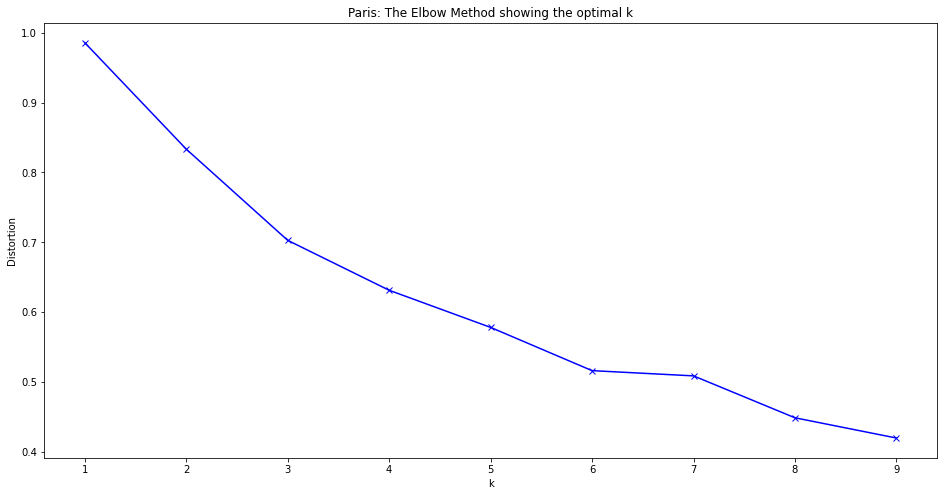

In [34]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions[0], 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Paris: The Elbow Method showing the optimal k')
plt.show()

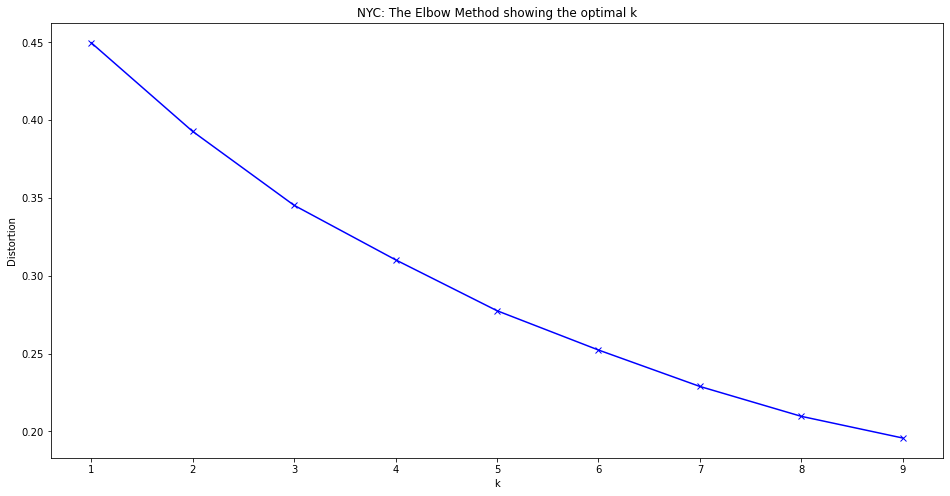

In [35]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions[1], 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('NYC: The Elbow Method showing the optimal k')
plt.show()

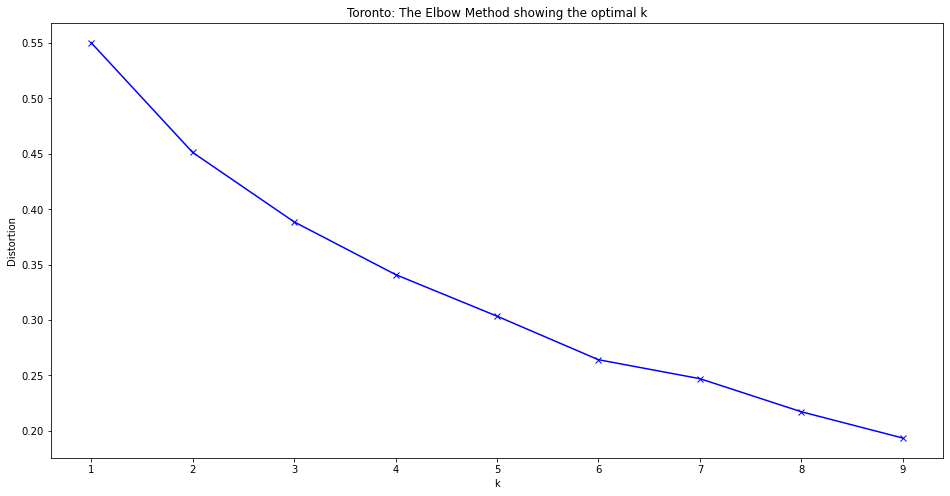

In [36]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions[2], 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Toronto: The Elbow Method showing the optimal k')
plt.show()

**The best values are** as follows

Paris:   k= 8

NYC:     k= 5

Toronto: k= 7

Let's **create maps showing the clusters for each city**.

In [37]:
# set number of clusters
kclusters = [8, 5, 7]
cities_kmeans = []

# run k-means clustering
for i in range(3):
    cities_kmeans.append(KMeans(n_clusters=kclusters[i], random_state=0).fit(venues_grouped_clustering[i]))

# check cluster labels generated for each row in the dataframe
    print(cities_kmeans[i].labels_[0:10] )


[6 1 6 3 4 3 5 1 7 3]
[3 1 3 3 1 2 1 1 1 2]
[0 0 4 0 2 0 0 0 5 5]


Create a new dataframe that includes the cluster as well as the top 10 venues for each coffee shop.


In [38]:
venues_merged = []

# add clustering labels
for i in range(3):
    neighborhoods_venues_sorted[i].insert(0, 'Cluster Labels', cities_kmeans[i].labels_)

    venues_merged.append(data_frames[i])

    venues_merged[i] = venues_merged[i].join(neighborhoods_venues_sorted[i].set_index('Neighborhood'), on='name')

In [39]:
venues_merged[0].head() # check the last columns!

,name,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Coffee Crêpes,48.858841,2.340802,3,French Restaurant,Hotel,Plaza,Café,Italian Restaurant,Cosmetics Shop,Pizza Place,Tea Room,Wine Bar,Restaurant
1,Coffee Parisien,48.852607,2.334536,5,Italian Restaurant,Hotel,French Restaurant,Café,Plaza,Sandwich Place,Bookstore,Bakery,Seafood Restaurant,Tea Room
2,Starbucks Coffee - kiosque,48.875763,2.358857,6,French Restaurant,Hotel,Bistro,Coffee Shop,Café,Bar,Breakfast Spot,Seafood Restaurant,Restaurant,Indian Restaurant
3,Super Wild Coffee,48.875763,2.358857,6,French Restaurant,Hotel,Bistro,Coffee Shop,Café,Bar,Breakfast Spot,Seafood Restaurant,Restaurant,Indian Restaurant
4,Thalone's Coffee,48.859264,2.348910,3,French Restaurant,Art Gallery,Pizza Place,Ice Cream Shop,Bar,Historic Site,Italian Restaurant,Japanese Restaurant,Furniture / Home Store,Fountain


In [40]:
venues_merged[1].head() # check the last columns!

,name,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Blue Spoon Coffee Co.,40.714428,-74.006859,2,Coffee Shop,Bakery,Gym / Fitness Center,Italian Restaurant,Sandwich Place,Park,Gym,Spa,American Restaurant,Dance Studio
1,Kam Hing Coffee Shop 金興,40.718017,-73.999210,4,Chinese Restaurant,Bakery,Café,Spa,Dessert Shop,Coffee Shop,Italian Restaurant,Optical Shop,Ice Cream Shop,Vietnamese Restaurant
2,For Five Coffee Roasters,40.709554,-74.010576,3,Coffee Shop,Hotel,Park,Clothing Store,Memorial Site,Pizza Place,Sandwich Place,Gym,Shopping Mall,Wine Shop
3,Coffee & Donut Cart,40.712689,-74.009985,2,Coffee Shop,Shopping Mall,Sandwich Place,Italian Restaurant,Hotel,Memorial Site,Clothing Store,Gym,Burger Joint,Pizza Place
4,Kaigo Coffee Room,40.718633,-74.000367,4,Chinese Restaurant,Coffee Shop,Bakery,Spa,Ice Cream Shop,Clothing Store,Art Gallery,Salon / Barbershop,Café,Asian Restaurant


In [41]:
venues_merged[2].head() # check the last columns!

,name,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,HotBlack Coffee,43.650364,-79.388669,0,Coffee Shop,Café,Movie Theater,Pizza Place,Restaurant,Clothing Store,Concert Hall,Sushi Restaurant,Burrito Place,Fast Food Restaurant
1,Timothy's World Coffee,43.653436,-79.382314,0,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Italian Restaurant,Japanese Restaurant,Gastropub,Seafood Restaurant,Middle Eastern Restaurant
2,Timothy's World Coffee,43.654053,-79.388090,0,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Italian Restaurant,Japanese Restaurant,Gastropub,Seafood Restaurant,Middle Eastern Restaurant
3,Timothy's World Coffee,43.654270,-79.387448,0,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Italian Restaurant,Japanese Restaurant,Gastropub,Seafood Restaurant,Middle Eastern Restaurant
4,Timothy's World Coffee,43.652135,-79.381172,0,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Italian Restaurant,Japanese Restaurant,Gastropub,Seafood Restaurant,Middle Eastern Restaurant


**Visualize the resulting clusters**.


In [42]:
# create map for each city
map_clusters = []

for j in range(3):
    #Location is the locations of each city
    map_clusters.append(folium.Map(location=[locations[j][0], locations[j][1]], zoom_start=11))

    # set color scheme for the clusters
    x = np.arange(kclusters[j])
    ys = [i + x + (i*x)**2 for i in range(kclusters[j])]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(venues_merged[j]['lat'], venues_merged[j]['lng'], venues_merged[j]['name'], venues_merged[j]['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters[j])
        
#map_clusters

In [43]:
map_clusters[0]

In [44]:
map_clusters[1]

In [45]:
map_clusters[2]

We can **examine the clusters** and **check what are the 10 most popular venues nearby** each coffee shop.


## Paris

#### Cluster 1


In [46]:
venues_merged[0].loc[venues_merged[0]['Cluster Labels'] == 0, venues_merged[0].columns[[0] + list(range(4, venues_merged[0].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Sun Coffee,Plaza,Hotel,French Restaurant,Coffee Shop,Japanese Restaurant,Bakery,Lebanese Restaurant,Bookstore,Cocktail Bar,Comic Shop
18,Lux Coffee,Hotel,French Restaurant,Café,Plaza,Bar,Wine Bar,Bistro,Cocktail Bar,Garden,Asian Restaurant
19,Siva's Lunch Coffee,Japanese Restaurant,French Restaurant,Hotel,Wine Bar,Italian Restaurant,Café,Udon Restaurant,Plaza,Korean Restaurant,Theater
44,Lazare Coffee Shop,French Restaurant,Hotel,Creperie,Café,Ice Cream Shop,Athletics & Sports,Italian Restaurant,Theater,Bar,Bistro


#### Cluster 2


In [47]:
venues_merged[0].loc[venues_merged[0]['Cluster Labels'] == 1, venues_merged[0].columns[[0] + list(range(4, venues_merged[0].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Steel Cyclewear & Coffeeshop,French Restaurant,Restaurant,Bar,Bakery,Wine Bar,Creperie,African Restaurant,Pizza Place,Japanese Restaurant,Bistro
35,Coffee Space Nouveau Sens,French Restaurant,Bar,Thai Restaurant,Bakery,Japanese Restaurant,Café,Hotel,Food & Drink Shop,Beer Store,Bistro
39,Arômes Coffee Shop,French Restaurant,Bar,Bistro,Restaurant,Bakery,Japanese Restaurant,Coffee Shop,Wine Bar,Cocktail Bar,Pizza Place
48,Coffee 80's,French Restaurant,Pizza Place,Hotel,Bar,Japanese Restaurant,Restaurant,Garden,Bakery,Café,Supermarket


#### Cluster 3


In [48]:
venues_merged[0].loc[venues_merged[0]['Cluster Labels'] == 2, venues_merged[0].columns[[0] + list(range(4, venues_merged[0].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Empire Coffee,Bus Stop,Brasserie,Southwestern French Restaurant,Theater,Movie Theater,Japanese Restaurant,Supermarket,Fast Food Restaurant,Falafel Restaurant,Farmers Market


#### Cluster 4


In [49]:
venues_merged[0].loc[venues_merged[0]['Cluster Labels'] == 3, venues_merged[0].columns[[0] + list(range(4, venues_merged[0].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Coffee Crêpes,French Restaurant,Hotel,Plaza,Café,Italian Restaurant,Cosmetics Shop,Pizza Place,Tea Room,Wine Bar,Restaurant
4,Thalone's Coffee,French Restaurant,Art Gallery,Pizza Place,Ice Cream Shop,Bar,Historic Site,Italian Restaurant,Japanese Restaurant,Furniture / Home Store,Fountain
6,Housey Coffee,French Restaurant,Ice Cream Shop,Italian Restaurant,Bakery,Café,Wine Bar,Plaza,Japanese Restaurant,Coffee Shop,Bistro
7,Motors Coffee,French Restaurant,Plaza,Hotel,Pizza Place,Clothing Store,Bar,Italian Restaurant,Japanese Restaurant,Cocktail Bar,Art Gallery
8,Costa Coffee,French Restaurant,Hotel,Indian Restaurant,Italian Restaurant,Sandwich Place,Japanese Restaurant,Bar,Bakery,Coffee Shop,Pizza Place
11,Coffee Break,French Restaurant,Italian Restaurant,Plaza,Spa,Bakery,Hotel,Historic Site,Pastry Shop,Clothing Store,Pizza Place
12,Gagao Organic Coffee-Shop,French Restaurant,Japanese Restaurant,Italian Restaurant,Pizza Place,Hotel,Restaurant,Clothing Store,Bakery,Shoe Store,Art Gallery
14,Savannah Coffee,French Restaurant,Hotel,Italian Restaurant,Bakery,Plaza,Clothing Store,Art Gallery,Tapas Restaurant,Falafel Restaurant,Tea Room
16,Coffee Shop,French Restaurant,Hotel,Italian Restaurant,Japanese Restaurant,Wine Bar,Pizza Place,Coffee Shop,Bistro,Restaurant,Cocktail Bar
17,Coffee Spoune,French Restaurant,Coffee Shop,Bakery,Clothing Store,Japanese Restaurant,Art Gallery,Café,Cocktail Bar,Restaurant,Bookstore


#### Cluster 5


In [50]:
venues_merged[0].loc[venues_merged[0]['Cluster Labels'] == 4, venues_merged[0].columns[[0] + list(range(4, venues_merged[0].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Caoua Coffee Stop,French Restaurant,Coffee Shop,Bar,Asian Restaurant,Bakery,Garden,Wine Bar,Breakfast Spot,Italian Restaurant,Pizza Place
30,Résidence Kann Coffee Shop,Coffee Shop,French Restaurant,Asian Restaurant,Bakery,Pizza Place,Breakfast Spot,Farmers Market,Garden,Bar,Italian Restaurant


#### Cluster 6


In [51]:
venues_merged[0].loc[venues_merged[0]['Cluster Labels'] == 5, venues_merged[0].columns[[0] + list(range(4, venues_merged[0].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Coffee Parisien,Italian Restaurant,Hotel,French Restaurant,Café,Plaza,Sandwich Place,Bookstore,Bakery,Seafood Restaurant,Tea Room
9,Starbucks Coffee - niveau métro,Hotel,French Restaurant,Italian Restaurant,Coffee Shop,Boutique,Wine Shop,Theater,Cosmetics Shop,Bistro,Salad Place
10,Starbucks Coffee - niveau quai,Hotel,French Restaurant,Italian Restaurant,Coffee Shop,Boutique,Wine Shop,Theater,Cosmetics Shop,Bistro,Salad Place
26,Coffee 22,French Restaurant,Hotel,Japanese Restaurant,Creperie,Italian Restaurant,Ice Cream Shop,Café,Pizza Place,Auvergne Restaurant,Department Store
32,Cup-Cup Coffee,French Restaurant,Hotel,Sandwich Place,Coffee Shop,Italian Restaurant,Bar,Bakery,Japanese Restaurant,Hotel Bar,Beer Bar
36,Coffee Parisien,Italian Restaurant,Hotel,French Restaurant,Café,Plaza,Sandwich Place,Bookstore,Bakery,Seafood Restaurant,Tea Room
45,Coffee Pub,Hotel,French Restaurant,Cosmetics Shop,Jewelry Store,Italian Restaurant,Japanese Restaurant,Boutique,Steakhouse,Clothing Store,Electronics Store
49,IWI Coffee,Hotel,French Restaurant,Bakery,Italian Restaurant,Bar,Corsican Restaurant,Wine Shop,Salad Place,Sandwich Place,Diner


#### Cluster 7


In [53]:
venues_merged[0].loc[venues_merged[0]['Cluster Labels'] == 6, venues_merged[0].columns[[0] + list(range(4, venues_merged[0].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Starbucks Coffee - kiosque,French Restaurant,Hotel,Bistro,Coffee Shop,Café,Bar,Breakfast Spot,Seafood Restaurant,Restaurant,Indian Restaurant
3,Super Wild Coffee,French Restaurant,Hotel,Bistro,Coffee Shop,Café,Bar,Breakfast Spot,Seafood Restaurant,Restaurant,Indian Restaurant
15,Araku Coffee,Hotel,Art Gallery,French Restaurant,Bistro,Wine Bar,Vietnamese Restaurant,Japanese Restaurant,Sandwich Place,Cocktail Bar,Burger Joint
20,Grain Coffee Shop,French Restaurant,Wine Bar,Coffee Shop,Theater,Hotel,Burger Joint,Vietnamese Restaurant,Italian Restaurant,Seafood Restaurant,Korean Restaurant
21,Fashion Coffee,Hotel,Cocktail Bar,Italian Restaurant,French Restaurant,Breakfast Spot,Vietnamese Restaurant,Art Gallery,Bakery,Pizza Place,Coffee Shop
22,République of Coffee,French Restaurant,Hotel,Wine Bar,Theater,Coffee Shop,Bakery,Burger Joint,Seafood Restaurant,Art Gallery,Italian Restaurant
24,Le Mellotron Coffee & Records,French Restaurant,Coffee Shop,Hotel,Asian Restaurant,Italian Restaurant,Wine Bar,Breakfast Spot,Korean Restaurant,Seafood Restaurant,Restaurant
25,le village epicerie coffee shop,Cocktail Bar,French Restaurant,Breakfast Spot,Bakery,Coffee Shop,Hotel,Pizza Place,Seafood Restaurant,Furniture / Home Store,Sandwich Place
29,Oni Coffee Shop,French Restaurant,Chinese Restaurant,Theater,Bar,Hotel,Cocktail Bar,Vietnamese Restaurant,Burger Joint,Italian Restaurant,Sandwich Place
40,Blackburn Coffee,Cocktail Bar,French Restaurant,Bakery,Breakfast Spot,Hotel,Pizza Place,Seafood Restaurant,Coffee Shop,Juice Bar,Salad Place


#### Cluster 8

In [54]:
venues_merged[0].loc[venues_merged[0]['Cluster Labels'] == 7, venues_merged[0].columns[[0] + list(range(4, venues_merged[0].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Costa Coffee - zone Eurostar,French Restaurant,Indian Restaurant,Hotel,Farmers Market,Japanese Restaurant,Bookstore,Restaurant,Record Shop,Bus Stop,Design Studio
41,Coffee Anjapper,Indian Restaurant,Hotel,French Restaurant,Theater,Italian Restaurant,Bakery,Supermarket,Chocolate Shop,Bistro,Dessert Shop


## NYC

#### Cluster 1


In [55]:
venues_merged[1].loc[venues_merged[1]['Cluster Labels'] == 0, venues_merged[1].columns[[0] + list(range(4, venues_merged[1].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Partners Coffee Roasters,Italian Restaurant,American Restaurant,Coffee Shop,Bakery,Ice Cream Shop,Seafood Restaurant,French Restaurant,Park,Cocktail Bar,Yoga Studio
29,Jack's Stir Brew Coffee,Italian Restaurant,American Restaurant,Coffee Shop,Seafood Restaurant,Restaurant,Ice Cream Shop,Café,Pizza Place,Indian Restaurant,Sandwich Place
30,Third Rail Coffee,Italian Restaurant,Pizza Place,Sushi Restaurant,Indian Restaurant,Wine Bar,Café,Sandwich Place,American Restaurant,Vietnamese Restaurant,Dog Run
43,McNulty's Tea & Coffee Co,Italian Restaurant,Coffee Shop,New American Restaurant,Cocktail Bar,American Restaurant,Sandwich Place,Wine Bar,Seafood Restaurant,Ice Cream Shop,Gay Bar
45,Coffee Wagon,Italian Restaurant,Coffee Shop,Pizza Place,Sushi Restaurant,American Restaurant,Mediterranean Restaurant,Dessert Shop,Sandwich Place,Hotel,Gym
47,Jack's Stir Brew Coffee,Italian Restaurant,American Restaurant,Coffee Shop,Seafood Restaurant,Restaurant,Ice Cream Shop,Café,Pizza Place,Indian Restaurant,Sandwich Place


#### Cluster 2


In [56]:
venues_merged[1].loc[venues_merged[1]['Cluster Labels'] == 2, venues_merged[1].columns[[0] + list(range(4, venues_merged[1].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Blue Spoon Coffee Co.,Coffee Shop,Bakery,Gym / Fitness Center,Italian Restaurant,Sandwich Place,Park,Gym,Spa,American Restaurant,Dance Studio
3,Coffee & Donut Cart,Coffee Shop,Shopping Mall,Sandwich Place,Italian Restaurant,Hotel,Memorial Site,Clothing Store,Gym,Burger Joint,Pizza Place
7,Hudson/Chambers Coffee Cart,Spa,American Restaurant,Italian Restaurant,Coffee Shop,Wine Shop,French Restaurant,Gym,Hotel,Korean Restaurant,Burger Joint
10,WFM Coffee Bar,Italian Restaurant,Coffee Shop,Hotel,Wine Shop,French Restaurant,American Restaurant,Spa,Sushi Restaurant,Gym,Bakery
15,Mary's Coffee Shop,Coffee Shop,Sandwich Place,Gym,American Restaurant,Hotel,Pizza Place,Falafel Restaurant,Italian Restaurant,Clothing Store,Burger Joint
21,WFM Coffee Bar,Italian Restaurant,Coffee Shop,Hotel,Wine Shop,French Restaurant,American Restaurant,Spa,Sushi Restaurant,Gym,Bakery
22,Kobrick Coffee Co.,Coffee Shop,Bakery,Shoe Store,Steakhouse,Roof Deck,Seafood Restaurant,Market,Hotel,New American Restaurant,Clothing Store
23,Dunkin' Iced Coffee Lounge at Z100,Art Gallery,Gym / Fitness Center,Italian Restaurant,Coffee Shop,American Restaurant,Men's Store,Hotel,French Restaurant,Spa,Café
24,Stumptown Coffee Roasters,Coffee Shop,Bakery,Italian Restaurant,Cocktail Bar,French Restaurant,Pizza Place,American Restaurant,Wine Bar,Wine Shop,Bagel Shop
28,Stumptown Coffee Roasters,Coffee Shop,Bakery,Italian Restaurant,Cocktail Bar,French Restaurant,Pizza Place,American Restaurant,Wine Bar,Wine Shop,Bagel Shop


#### Cluster 3


In [57]:
venues_merged[1].loc[venues_merged[1]['Cluster Labels'] == 3, venues_merged[1].columns[[0] + list(range(4, venues_merged[1].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,For Five Coffee Roasters,Coffee Shop,Hotel,Park,Clothing Store,Memorial Site,Pizza Place,Sandwich Place,Gym,Shopping Mall,Wine Shop
5,For Five Coffee Roasters,Coffee Shop,Hotel,Park,Clothing Store,Memorial Site,Pizza Place,Sandwich Place,Gym,Shopping Mall,Wine Shop
8,Coffee Cart C0549,Coffee Shop,Italian Restaurant,Pizza Place,Hotel,American Restaurant,Sandwich Place,Wine Shop,Gym,Juice Bar,Falafel Restaurant
9,Gregorys Coffee,Coffee Shop,Gym,American Restaurant,Pizza Place,Cocktail Bar,Italian Restaurant,Mexican Restaurant,Gym / Fitness Center,Bar,Hotel
11,Gregorys Coffee,Coffee Shop,Gym,American Restaurant,Pizza Place,Cocktail Bar,Italian Restaurant,Mexican Restaurant,Gym / Fitness Center,Bar,Hotel
12,John & William St. Coffee Cart,Coffee Shop,Italian Restaurant,American Restaurant,Pizza Place,Hotel,Sandwich Place,Juice Bar,Falafel Restaurant,Deli / Bodega,Greek Restaurant
13,Proof Coffee Roaster,Coffee Shop,Italian Restaurant,Pizza Place,Hotel,American Restaurant,Wine Shop,Jewelry Store,Clothing Store,Restaurant,Greek Restaurant
14,Nick's Coffee Truck,Coffee Shop,Italian Restaurant,American Restaurant,Pizza Place,Seafood Restaurant,Falafel Restaurant,Sandwich Place,Café,Restaurant,Mexican Restaurant
18,Birch Coffee,Coffee Shop,Italian Restaurant,Hotel,Pizza Place,Indian Restaurant,Sandwich Place,Gym,Falafel Restaurant,Deli / Bodega,Gym / Fitness Center
20,Periscope Coffee On John Street,Italian Restaurant,Coffee Shop,American Restaurant,Juice Bar,Café,Pizza Place,Restaurant,Falafel Restaurant,Seafood Restaurant,Salad Place


#### Cluster 4


In [58]:
venues_merged[1].loc[venues_merged[1]['Cluster Labels'] == 4, venues_merged[1].columns[[0] + list(range(4, venues_merged[1].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Kam Hing Coffee Shop 金興,Chinese Restaurant,Bakery,Café,Spa,Dessert Shop,Coffee Shop,Italian Restaurant,Optical Shop,Ice Cream Shop,Vietnamese Restaurant
4,Kaigo Coffee Room,Chinese Restaurant,Coffee Shop,Bakery,Spa,Ice Cream Shop,Clothing Store,Art Gallery,Salon / Barbershop,Café,Asian Restaurant
6,Coffee Cart,Chinese Restaurant,Spa,Bakery,Coffee Shop,Dim Sum Restaurant,Dessert Shop,Bubble Tea Shop,Japanese Restaurant,Jewelry Store,Falafel Restaurant


## Toronto

#### Cluster 1


In [59]:
venues_merged[2].loc[venues_merged[2]['Cluster Labels'] == 0, venues_merged[2].columns[[0] + list(range(4, venues_merged[2].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,HotBlack Coffee,Coffee Shop,Café,Movie Theater,Pizza Place,Restaurant,Clothing Store,Concert Hall,Sushi Restaurant,Burrito Place,Fast Food Restaurant
1,Timothy's World Coffee,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Italian Restaurant,Japanese Restaurant,Gastropub,Seafood Restaurant,Middle Eastern Restaurant
2,Timothy's World Coffee,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Italian Restaurant,Japanese Restaurant,Gastropub,Seafood Restaurant,Middle Eastern Restaurant
3,Timothy's World Coffee,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Italian Restaurant,Japanese Restaurant,Gastropub,Seafood Restaurant,Middle Eastern Restaurant
4,Timothy's World Coffee,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Italian Restaurant,Japanese Restaurant,Gastropub,Seafood Restaurant,Middle Eastern Restaurant
5,Coffee office,Coffee Shop,Café,Sushi Restaurant,Hotel,Steakhouse,Thai Restaurant,Pizza Place,Seafood Restaurant,Movie Theater,Concert Hall
6,Fahrenheit Coffee,Coffee Shop,Café,Restaurant,Gym,Furniture / Home Store,Italian Restaurant,Hotel,Seafood Restaurant,Pizza Place,Cosmetics Shop
7,Timothy's World Coffee,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Italian Restaurant,Japanese Restaurant,Gastropub,Seafood Restaurant,Middle Eastern Restaurant
9,Timothy's World Coffee,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Italian Restaurant,Japanese Restaurant,Gastropub,Seafood Restaurant,Middle Eastern Restaurant
10,Timothy's World Coffee,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Italian Restaurant,Japanese Restaurant,Gastropub,Seafood Restaurant,Middle Eastern Restaurant


#### Cluster 2


In [60]:
venues_merged[2].loc[venues_merged[2]['Cluster Labels'] == 1, venues_merged[2].columns[[0] + list(range(4, venues_merged[2].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Sam James Coffee Bar Oz,Bar,Restaurant,Asian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Café,Men's Store,Cocktail Bar,Japanese Restaurant,Boutique


#### Cluster 3


In [61]:
venues_merged[2].loc[venues_merged[2]['Cluster Labels'] == 2, venues_merged[2].columns[[0] + list(range(4, venues_merged[2].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Coffee Culture Cafe & Eatery,Café,Taco Place,Bar,Bakery,Burger Joint,Ice Cream Shop,Comic Shop,Vegetarian / Vegan Restaurant,Coffee Shop,Beer Bar
28,Super Jet International Coffee Shop,Café,Vegetarian / Vegan Restaurant,Mexican Restaurant,Bar,Coffee Shop,Burger Joint,Vietnamese Restaurant,Pub,Caribbean Restaurant,Brewery
29,I Deal Coffee,Café,Bar,Vegetarian / Vegan Restaurant,Mexican Restaurant,Burger Joint,Taco Place,Coffee Shop,Vietnamese Restaurant,Comic Shop,Record Shop
38,Jimmy's Coffee,Café,Coffee Shop,Bar,Vegetarian / Vegan Restaurant,Mexican Restaurant,Vietnamese Restaurant,Burger Joint,Pizza Place,Gaming Cafe,Grocery Store


#### Cluster 4


In [62]:
venues_merged[2].loc[venues_merged[2]['Cluster Labels'] == 3, venues_merged[2].columns[[0] + list(range(4, venues_merged[2].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Second Cup Coffee Co. featuring Pinkberry Froz...,Coffee Shop,Café,Sandwich Place,Japanese Restaurant,Bank,Chinese Restaurant,Bar,Sushi Restaurant,Fried Chicken Joint,Bookstore
19,Second Cup Coffee Co. featuring Pinkberry Froz...,Coffee Shop,Café,Sandwich Place,Japanese Restaurant,Bank,Chinese Restaurant,Bar,Sushi Restaurant,Fried Chicken Joint,Bookstore
21,T.A.N. Coffee,Coffee Shop,Sandwich Place,Café,Fried Chicken Joint,Vietnamese Restaurant,Restaurant,Arts & Crafts Store,Bank,Pharmacy,Sushi Restaurant
39,NEO COFFEE BAR,Coffee Shop,Sandwich Place,Café,Middle Eastern Restaurant,Italian Restaurant,Bookstore,Movie Theater,Pharmacy,Spa,Creperie


#### Cluster 5


In [63]:
venues_merged[2].loc[venues_merged[2]['Cluster Labels'] == 4, venues_merged[2].columns[[0] + list(range(4, venues_merged[2].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Coffee Antidote 9th Floor,Café,Art Gallery,Coffee Shop,French Restaurant,Japanese Restaurant,Bubble Tea Shop,Chinese Restaurant,Ramen Restaurant,Donut Shop,Juice Bar
40,The Library Specialty Coffee,Chinese Restaurant,Café,Art Gallery,Coffee Shop,French Restaurant,Japanese Restaurant,Tea Room,Dumpling Restaurant,Korean Restaurant,Ramen Restaurant


#### Cluster 6


In [64]:
venues_merged[2].loc[venues_merged[2]['Cluster Labels'] == 5, venues_merged[2].columns[[0] + list(range(4, venues_merged[2].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Treats Coffee Emporium,Coffee Shop,Clothing Store,Restaurant,Hotel,Cosmetics Shop,Tanning Salon,Plaza,Thai Restaurant,Theater,Diner
34,Seattle's Best Coffee,Coffee Shop,Clothing Store,Cosmetics Shop,Electronics Store,Plaza,Middle Eastern Restaurant,Bookstore,Café,Sushi Restaurant,Sporting Goods Shop
42,Smokes'N Coffee,Coffee Shop,Clothing Store,Sandwich Place,Middle Eastern Restaurant,Bubble Tea Shop,Theater,Electronics Store,Hotel,Café,Ramen Restaurant
44,Mos Mos Coffee,Coffee Shop,Sandwich Place,Italian Restaurant,Clothing Store,Burger Joint,Pizza Place,Sushi Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Diner
46,Hailed Coffee,Coffee Shop,Sushi Restaurant,Burger Joint,Japanese Restaurant,Sandwich Place,Hotel,Bubble Tea Shop,Tea Room,Clothing Store,Italian Restaurant
47,Fresh Start Coffee Company,Coffee Shop,Clothing Store,Sandwich Place,Bubble Tea Shop,Diner,Electronics Store,Hotel,Ramen Restaurant,Plaza,Pizza Place


#### Cluster 7


In [65]:
venues_merged[2].loc[venues_merged[2]['Cluster Labels'] == 6, venues_merged[2].columns[[0] + list(range(4, venues_merged[2].shape[1]))]]

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Rooster Coffee House,Coffee Shop,Grocery Store,Restaurant,Japanese Restaurant,Fast Food Restaurant,Sandwich Place,Breakfast Spot,Café,Hotel,Mediterranean Restaurant


We analize **whether there is a correlation between coffee shops vs venues** nearby.

First, **merge all frequencies data frames** and replaces Nan values by zero.

In [66]:
# Merge the ddata frames
venues_grouped_concatenated = pd.concat([venues_grouped[0], venues_grouped[1], venues_grouped[2]], ignore_index=True, sort=False)

#Replaces Nan values by zero
venues_grouped_concatenated = venues_grouped_concatenated.replace(0, np.nan)

print(venues_grouped_concatenated.shape)
#venues_grouped_concatenated

(119, 373)


In [67]:
venues_grouped_concatenated_zeros = venues_grouped_concatenated.fillna(0)
venues_grouped_concatenated_zeros = venues_grouped_concatenated_zeros.set_index('Neighborhood')
venues_grouped_concatenated_zeros.head()


,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basque Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Candy Store,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Doner Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General College & University,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Resort,Restaurant,Rock Club,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,South American Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Accessories Store,Animal Shelter,Arcade,Auditorium,Australian Restaurant,Austrian Restaurant,Baby Store,Baseball Field,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Building,Burrito Place,Cantonese Restaurant,Cha Chaan Teng,Club House,College Theater,Cooking School,Coworking Space,Cuban Restaurant,Dance Studio,Discount Store,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Event Space

**Basic statistics.**

In [68]:
venues_grouped_concatenated.describe()

,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basque Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Candy Store,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Doner Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General College & University,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Resort,Restaurant,Rock Club,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,South American Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Accessories Store,Animal Shelter,Arcade,Auditorium,Australian Restaurant,Austrian Restaurant,Baby Store,Baseball Field,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Building,Burrito Place,Cantonese Restaurant,Cha Chaan Teng,Club House,College Theater,Cooking School,Coworking Space,Cuban Restaurant,Dance Studio,Discount Store,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Event Space

In [69]:
venues_statistics_sorted = venues_grouped_concatenated.describe().sort_values(by ='count', axis=1)
venues_statistics_droped =  venues_statistics_sorted

**Drop the colums that have count less than 60**.

In [70]:
venues_statistics_droped = venues_statistics_droped.drop(venues_statistics_droped.columns[venues_statistics_droped.apply(lambda col: col['count'] <= 60)], axis=1)
venues_statistics_droped

,Salad Place,Wine Bar,Vegetarian / Vegan Restaurant,Bookstore,Burger Joint,Park,Cocktail Bar,Sandwich Place,Bar,Restaurant,Pizza Place,French Restaurant,Bakery,Japanese Restaurant,Hotel,Italian Restaurant,Café,Coffee Shop
count,64.000000,66.000000,68.000000,69.000000,72.000000,75.000000,80.000000,80.000000,82.000000,87.000000,91.000000,93.000000,93.000000,94.000000,99.000000,104.000000,108.000000,109.000000
mean,0.014621,0.019269,0.016316,0.015117,0.016767,0.016419,0.021451,0.025293,0.028269,0.024108,0.025774,0.070836,0.029724,0.024636,0.047386,0.040157,0.034941,0.063127
std,0.006156,0.011550,0.010846,0.007160,0.008972,0.008765,0.012861,0.019736,0.024468,0.015220,0.014227,0.065316,0.018862,0.019164,0.040283,0.027163,0.026264,0.041309
min,0.005000,0.003333,0.003333,0.005000,0.002500,0.004149,0.006002,0.005000,0.003774,0.003333,0.010000,0.003774,0.008403,0.005000,0.010000,0.010000,0.010000,0.006536
25%,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.012487,0.013247,0.012540,0.012823,0.016363,0.018182,0.015000,0.010000,0.020000,0.020000,0.016263,0.034483
50%,0.012274,0.014939,0.011696,0.011765,0.014036,0.014406,0.020000,0.020000,0.020621,0.020000,0.020000,0.040000,0.021277,0.020000,0.032609,0.036365,0.027480,0.053763
75%,0.020000,0.028750,0.020000,0.020000,0.020102,0.020000,0.025539,0.030000,0.030000,0.030000,0.030873,0.110000,0.040000,0.032090,0.061120,0.050000,0.046187,0.079365
max,0.030000,0.050000,0.053333,0.040816,0.040000,0.060000,0.066667,0.142857,0.130000,0.080000,0.093750,0.255319,0.088235,0.111111,0.213115,0.150000,0.123077,0.229508


In [71]:
venues_statistics_droped.keys()

Index(['Salad Place', 'Wine Bar', 'Vegetarian / Vegan Restaurant', 'Bookstore',
       'Burger Joint', 'Park', 'Cocktail Bar', 'Sandwich Place', 'Bar',
       'Restaurant', 'Pizza Place', 'French Restaurant', 'Bakery',
       'Japanese Restaurant', 'Hotel', 'Italian Restaurant', 'Café',
       'Coffee Shop'],
      dtype='object')

In [72]:
#venues_grouped_concatenated_zeros.head()
venues_sample = venues_grouped_concatenated_zeros[venues_statistics_droped.keys()]
venues_sample.head()

,Salad Place,Wine Bar,Vegetarian / Vegan Restaurant,Bookstore,Burger Joint,Park,Cocktail Bar,Sandwich Place,Bar,Restaurant,Pizza Place,French Restaurant,Bakery,Japanese Restaurant,Hotel,Italian Restaurant,Café,Coffee Shop
Neighborhood,,,,,,,,,,,,,,,,,,
Araku Coffee,0.000000,0.042857,0.014286,0.014286,0.028571,0.014286,0.042857,0.042857,0.028571,0.014286,0.014286,0.057143,0.014286,0.042857,0.071429,0.028571,0.014286,0.014286
Arômes Coffee Shop,0.000000,0.030000,0.000000,0.020000,0.020000,0.010000,0.030000,0.010000,0.130000,0.040000,0.030000,0.150000,0.040000,0.030000,0.000000,0.020000,0.010000,0.030000
Blackburn Coffee,0.022222,0.022222,0.022222,0.000000,0.022222,0.000000,0.066667,0.022222,0.022222,0.022222,0.044444,0.066667,0.066667,0.000000,0.066667,0.000000,0.022222,0.044444
Bombay Coffee,0.000000,0.000000,0.000000,0.000000,0.000000,0.013514,0.000000,0.000000,0.013514,0.000000,0.000000,0.135135,0.067568,0.027027,0.054054,0.054054,0.067568,0.013514
Caoua Coffee Stop,0.015873,0.031746,0.015873,0.015873,0.000000,0.000000,0.000000,0.000000,0.063492,0.015873,0.031746,0.079365,0.047619,0.015873,0.000000,0.031746,0.015873,0.079365


**Create a Heatmap**.

In [74]:
import seaborn as sns

<AxesSubplot:>

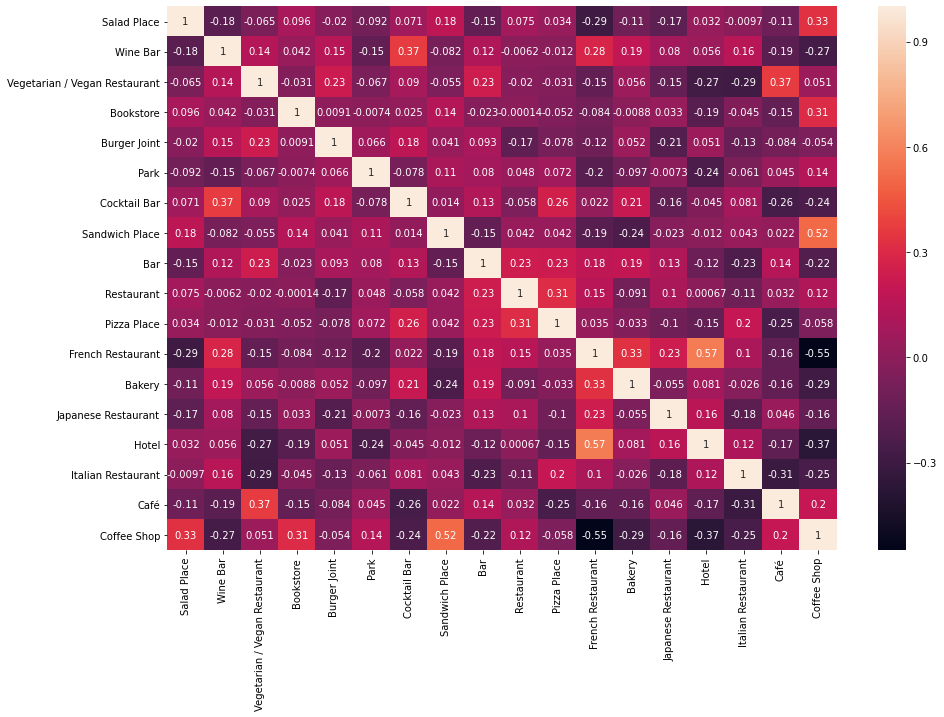

In [75]:
plt.subplots(figsize=(15,10))
sns.heatmap(venues_sample.corr(), annot=True)


## Results and Discussion <a name="results"></a>

Through this report it was given dataframes, maps and graphics showing the name of venues and its location, the geographical location and the optimal values to fit the classification model by k-means, respectively. 

Our analysis shows that ~500 meters around the location of every coffee shop there exists a wide variety of venues. In other words, the presence of a coffee shop indicates a good source of income to the area. And vice versa, the high concentration of these venues in a particular area suggests that there should be a coffee shop nearby ~500 meters. 

Notice that even though we analyzed coffee shops in different countries, the type of venues around are very similar. To name some we have: Restaurant, Gym, Bar, Clothing Store, Sandwich Places, etc. So stakeholders interested in opening a new branch coffee shop in a potentially multicultural city must consider locations or neighborhoods that contain the venues mentioned above. 

It is important to observe that the existance of a coffee shop doesn't imply that new competition has no oportunity to succeed. In fact, we can observe on the maps that in neighborhoods that contain Restaurants, Gyms and Bars the density of coffee places is around 4 to 5 within a radius of 500 meters. Stakeholders are encourage to consider locations with these caracteristics with no more that 3 coffee shops nearby.

We have found that the optimal cluster for the cities are as follows: Paris 8, NYC 4, Toronto 7. Paris and Toronto have a huge cluster whereas NYC contains two big ones. The rest of the cluster are kind of uniform and with similar venues around. 

Finally, in the last part of the analysis we merged all dataframes with all venues around each coffee shop. Then we created a heat map which shows that there is no correlation between coffee shops and any other venue perhaps with the exeption of Sandwich Places. There is a correlation Coffee Shops vs Sanswich Places of 0.52. This number is not particularly high but is an insight that stakeholders would like to keep an eye on.


## Conclusion <a name="results"></a>

Purpose of this project was to find (dis)similarities among coffee shops around the center of the cities of Paris, NYC and Toronto (we restricted the analysis of NYC to the Burough of Manhatan) in order to aid stakeholders in narrowing down the search for the optimal location for a new branch coffee place in multicultural cities. By calculating the density and types of venues nearby from Foursquare data we have first identified general venues to justify further analysis, and then filter the data to the most popular venues around since this is a good parameter of orientation for tourists. Clustering of coffee shops was then performed which helps stakeholders visualize the (dis)similarities and find out insights of why it is reliable to open a new cofee place.

We can recommend stakeholders by the number of clusters and type of venues that Paris and Toronto are more alike than NYC. Moreover, new coffee shops should be places on locations with nor more that 3 coffe places within a radius of 500 meters but containing Sandwich Places, Restaurants, Gyms and Bars.